In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import html
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords

from keras.utils.vis_utils import plot_model
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, Conv1D, Dropout, MaxPooling1D, Bidirectional, LSTM, Flatten, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
## Read dataframes, set binary column to identify fake news article and concat the two dataframes into a single dataframe

fake_news = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
true_news = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

fake_news['is_fake'] = 1
true_news['is_fake']= 0

df = pd.concat([fake_news, true_news])
print(df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  is_fake  
0  December 31, 2017        1  
1  December 31, 2017        1  
2  December 30, 2017        1  
3  December 29, 2017        1  
4  December 25, 2017        1  


In [3]:
## Basic Numbers
print('Before dropping duplicates: Rows: {}'.format(df.shape[0]))
print("\n")
print("The number of null titles is {}".format(df[df.title.isna()].shape[0]))
print('\n')
print("The number of blank titles is {}".format(df[df.title==''].shape[0]))

Before dropping duplicates: Rows: 44898


The number of null titles is 0


The number of blank titles is 0


In [4]:
## Subject Distributions
print("The distribution of news subjects is:")
print("\n")
print(df.subject.value_counts())

The distribution of news subjects is:


politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


In [5]:
## Number of rows after deduplication
df.drop_duplicates(inplace=True)
print('After dropping duplicates: Rows: {}'.format(df.shape[0]))

After dropping duplicates: Rows: 44689


In [6]:
## Distribution for fake and not fake articles
print("The distribution of fake labels is:")
print("\n")
print(df.is_fake.value_counts())

The distribution of fake labels is:


1    23478
0    21211
Name: is_fake, dtype: int64


<AxesSubplot:xlabel='subject', ylabel='count'>

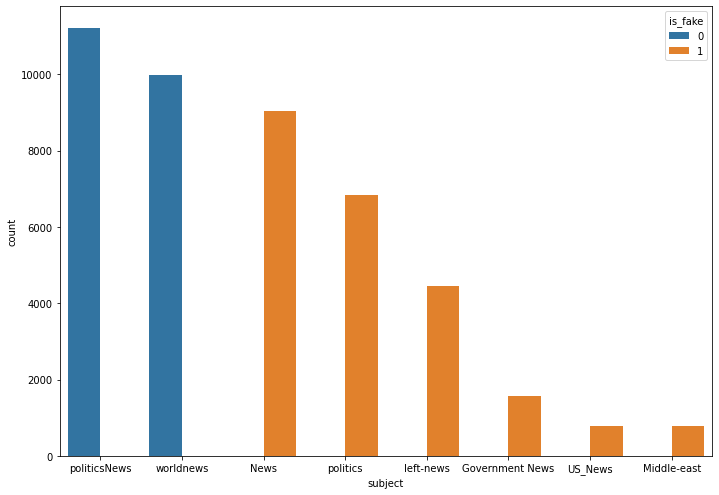

In [7]:
## Distribution of subjects by fake and not fake
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x='subject', data=df, hue='is_fake', order = df['subject'].value_counts().index )

In [8]:
## Basic Text Cleanup
def clean_text(text):
    text = html.unescape(text)  # Unescape string
    text = re.sub('(ht|f)tp[s]?://\S+', '', text)  # Remove links
    text = re.sub('\S*@\S*\s?', '', text)  # Remove e-mail addresses
    text = text.replace("'", '').replace('’', '').replace('‘', '')  # Preserve contractions
    text = re.sub('([^\s\w]|_)+', ' ', text)  # Remove remaining punctuation
    text = text.strip().lower()  # Strip all leading and trailing whitespace and make all lowercase
    text = text.replace('œ', ' ')  # This character exists between two words with no space so replacing with space instead of removing completely
    text = ' '.join([re.sub(r'[^a-zA-Z0-9]', '', w) for w in text.split(' ')])  # Remove special characters
    text = text.replace('\r\n', '')  # This is present only in the abuse queue posts
    text = re.sub('\s{2,}', ' ', text)  # Repalce multiple spaces with one space
    text = text.strip()  # Strip all leading and trailing whitespace that might have been added
    return text

## Concatenate title and body and clean text
df['title_body'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['title_body'].apply(lambda x: clean_text(x))

## Remove stopwords from text
stop = stopwords.words('english')
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print("The total number of words is {}".format(df['cleaned_text'].apply(lambda x: len(x.split())).sum()))

The total number of words is 11094805


In [9]:
## create an embedding vector using fasttext word embeddings 
embedding_vector = {}
f = open('../input/fasttext-embeddings/wiki-news-300d-1M.vec')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:], dtype = 'float32')
    embedding_vector[word] = coef

999995it [00:58, 17006.17it/s]


In [10]:
## Split data into test and train
X = df['cleaned_text']
y = df['is_fake']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
print("The number of words in the training are {}".format(X_train.apply(lambda x: len(x.split())).sum()))

The number of words in the training are 7763156


In [11]:
## Initiate tokenizer class, fit on X_train, convert to sequences and then pad them
## Sequences length padding is defaulted to the length of the longest sequence in the sequenced text
token = Tokenizer(num_words=8000000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
token.fit_on_texts(X_train)
train_sequences = token.texts_to_sequences(X_train)
padded_train_seq = pad_sequences(train_sequences)
vocab_size = len(token.word_index)+1
print("The maximum sequence length is {}".format(padded_train_seq.shape[1]))

The maximum sequence length is 5081


In [12]:
## Create an embedding matrix from the vocabulary in X_train and the embedding vector
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 99117/99117 [00:00<00:00, 349579.12it/s]


2022-08-20 00:24:04.658896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 00:24:04.755999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 00:24:04.756799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 00:24:04.758454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5081)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 5081, 300)         29735400  
_________________________________________________________________
conv1d (Conv1D)              (None, 5079, 32)          28832     
_________________________________________________________________
dropout (Dropout)            (None, 5079, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2539, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                6272      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0     

2022-08-20 00:24:07.855603: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 445034628 exceeds 10% of free system memory.
2022-08-20 00:24:08.258595: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-20 00:24:11.757229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1369/1369 [==============================] - 220s 154ms/step - loss: 0.1934 - accuracy: 0.9252 - val_loss: 0.2272 - val_accuracy: 0.9109
Epoch 2/10
1369/1369 [==============================] - 209s 153ms/step - loss: 0.1520 - accuracy: 0.9447 - val_loss: 0.1009 - val_accuracy: 0.9579
Epoch 3/10
1369/1369 [==============================] - 210s 154ms/step - loss: 0.0753 - accuracy: 0.9727 - val_loss: 0.0128 - val_accuracy: 0.9970
Epoch 4/10
1369/1369 [==============================] - 211s 154ms/step - loss: 0.0714 - accuracy: 0.9753 - val_loss: 0.0483 - val_accuracy: 0.9841
Epoch 5/10
1369/1369 [==============================] - 211s 154ms/step - loss: 0.0517 - accuracy: 0.9840 - val_loss: 0.0288 - val_accuracy: 0.9950
Epoch 6/10
1369/1369 [==============================] - 211s 154ms/step - loss: 0.0287 - accuracy: 0.9913 - val_loss: 0.0088 - val_accuracy: 0.9979
Epoch 7/10
1369/1369 [==============================] - 211s 154ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.007

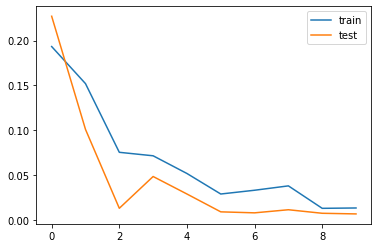

In [13]:
## Create functional keras model with early stopping based on minimum validation loss
inputs1 = Input(shape=(5081,))
embedding1 = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='valid')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
lstm1 = Bidirectional(LSTM(16))(pool1)
flat1 = Flatten()(lstm1)
dense1 = Dense(10, activation='relu')(flat1)
outputs = Dense(2, activation='softmax')(dense1)
model = Model(inputs=inputs1, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
print(model.summary())
print("\n")

es = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True,patience=20, verbose=1)
checkpoint = ModelCheckpoint(filepath="/kaggle/working/best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5",
                            monitor='val_loss',save_best_only=True, mode='min')
callbacks = [es,checkpoint]

history = model.fit(padded_train_seq, np.array(y_train), validation_split=0.3, epochs=10, batch_size=16, callbacks=callbacks)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()